In [2]:
# 📌 Notebook 4: Inference & Integration (Clean Final Version)

import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- 1. Load trained models ---
delay_model = joblib.load("../models/delay_prediction_xgb.pkl")
churn_pipeline = joblib.load("../models/final_churn_pipeline.pkl")

# --- 2. Load cleaned dataset ---
data_path = "../data/cleaned_amazon_delivery.csv"
new_data = pd.read_csv(data_path)

# --- 3. Feature Engineering (same as training) ---
# Explicit datetime parsing to avoid warnings
new_data['Order_Hour'] = pd.to_datetime(
    new_data['Order_Time'], format='%H:%M:%S', errors='coerce'
).dt.hour

new_data['Order_DayOfWeek'] = pd.to_datetime(
    new_data['Order_Date'], format='%Y-%m-%d', errors='coerce'
).dt.dayofweek

new_data['Order_Month'] = pd.to_datetime(
    new_data['Order_Date'], format='%Y-%m-%d', errors='coerce'
).dt.month

# Distance feature
new_data['Distance_km'] = np.sqrt(
    (new_data['Store_Latitude'] - new_data['Drop_Latitude'])**2 +
    (new_data['Store_Longitude'] - new_data['Drop_Longitude'])**2
)

# --- 4. Encode categorical columns ---
categorical_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for col in categorical_cols:
    if col in new_data.columns:
        new_data[col] = new_data[col].fillna("Unknown").astype(str)
        le = LabelEncoder()
        new_data[col] = le.fit_transform(new_data[col]).astype(int)

# --- 5. Predict Delay ---
delay_features = [
    'Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle',
    'Area', 'Category', 'Order_Hour', 'Order_DayOfWeek',
    'Order_Month', 'Distance_km'
]

X_delay = new_data[delay_features].fillna(0).astype(float)
new_data['Delay_Prediction'] = delay_model.predict(X_delay)
new_data['Delay_Probability'] = delay_model.predict_proba(X_delay)[:, 1]

# Create Is_Delayed column (needed for churn pipeline)
new_data['Is_Delayed'] = new_data['Delay_Prediction']

# --- 6. Predict Churn ---
X_churn = new_data.drop(columns=['Churned'], errors='ignore')
new_data['Churn_Prediction'] = churn_pipeline.predict(X_churn)

# --- 7. Save results ---
output_path = "../data/final_predictions.csv"
new_data.to_csv(output_path, index=False)

print("✅ Predictions complete! File saved to:", output_path)
new_data.head()


✅ Predictions complete! File saved to: ../data/final_predictions.csv


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,...,Delivery_Duration_Minutes,Is_Delayed,Churned,Order_Hour,Order_DayOfWeek,Order_Month,Distance_km,Delay_Prediction,Delay_Probability,Churn_Prediction
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,2022-03-19 11:45:00,...,120.0,0,0,11.0,5,3,0.028284,0,0.002577,0
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,2022-03-25 19:50:00,...,165.0,1,0,19.0,4,3,0.183848,1,0.998834,0
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,2022-03-19 08:45:00,...,130.0,0,0,8.0,5,3,0.014142,0,0.119285,0
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,2022-04-05 18:10:00,...,105.0,0,0,18.0,1,4,0.070711,0,0.052083,0
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,2022-03-26 13:45:00,...,150.0,1,0,13.0,5,3,0.056569,1,0.992815,0


In [3]:
# --- 8. Summary Report ---
total_orders = len(new_data)
delayed_pct = new_data['Delay_Prediction'].mean() * 100
churned_pct = new_data['Churn_Prediction'].mean() * 100

print("\n📊 Summary Report")
print(f"Total Orders Processed: {total_orders}")
print(f"Predicted Delayed Orders: {delayed_pct:.2f}%")
print(f"Predicted Churned Customers: {churned_pct:.2f}%")

print("\n🔍 Sample Predictions:")
print(new_data[['Order_ID', 'Delay_Prediction', 'Delay_Probability', 'Churn_Prediction']].head())



📊 Summary Report
Total Orders Processed: 43739
Predicted Delayed Orders: 38.46%
Predicted Churned Customers: 0.09%

🔍 Sample Predictions:
        Order_ID  Delay_Prediction  Delay_Probability  Churn_Prediction
0  ialx566343618                 0           0.002577                 0
1  akqg208421122                 1           0.998834                 0
2  njpu434582536                 0           0.119285                 0
3  rjto796129700                 0           0.052083                 0
4  zguw716275638                 1           0.992815                 0


C:\Users\HP\AppData\Local\Temp\ipykernel_19936\4072012952.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_counts.index, y=delay_counts.values, palette="coolwarm")
C:\Users\HP\AppData\Local\Temp\ipykernel_19936\4072012952.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")


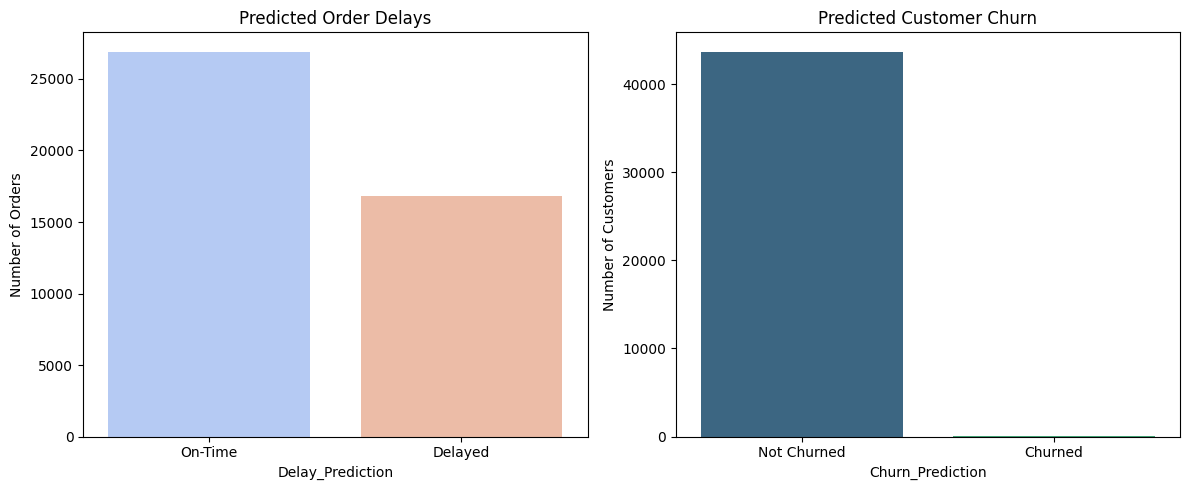

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load final predictions ---
data_path = "../data/final_predictions.csv"
df = pd.read_csv(data_path)

# --- Summary counts ---
delay_counts = df['Delay_Prediction'].value_counts().sort_index()
churn_counts = df['Churn_Prediction'].value_counts().sort_index()

# --- Set up plots ---
plt.figure(figsize=(12,5))

# Delays
plt.subplot(1, 2, 1)
sns.barplot(x=delay_counts.index, y=delay_counts.values, palette="coolwarm")
plt.xticks([0,1], ['On-Time', 'Delayed'])
plt.ylabel("Number of Orders")
plt.title("Predicted Order Delays")

# Churn
plt.subplot(1, 2, 2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.xticks([0,1], ['Not Churned', 'Churned'])
plt.ylabel("Number of Customers")
plt.title("Predicted Customer Churn")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Predicted Customer Churn')

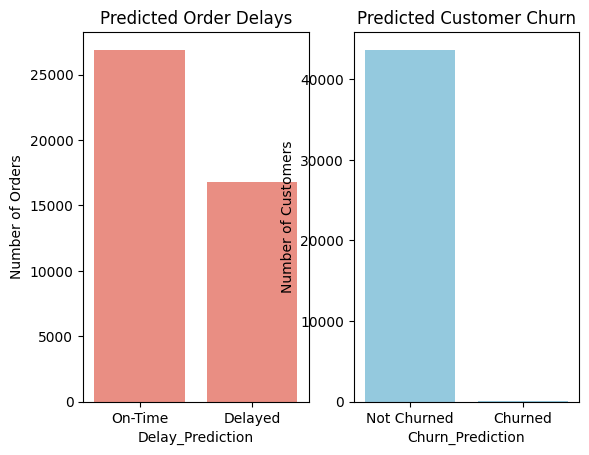

In [5]:
# Delays
plt.subplot(1, 2, 1)
sns.barplot(x=delay_counts.index, y=delay_counts.values, color="salmon")
plt.xticks([0,1], ['On-Time', 'Delayed'])
plt.ylabel("Number of Orders")
plt.title("Predicted Order Delays")

# Churn
plt.subplot(1, 2, 2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, color="skyblue")
plt.xticks([0,1], ['Not Churned', 'Churned'])
plt.ylabel("Number of Customers")
plt.title("Predicted Customer Churn")


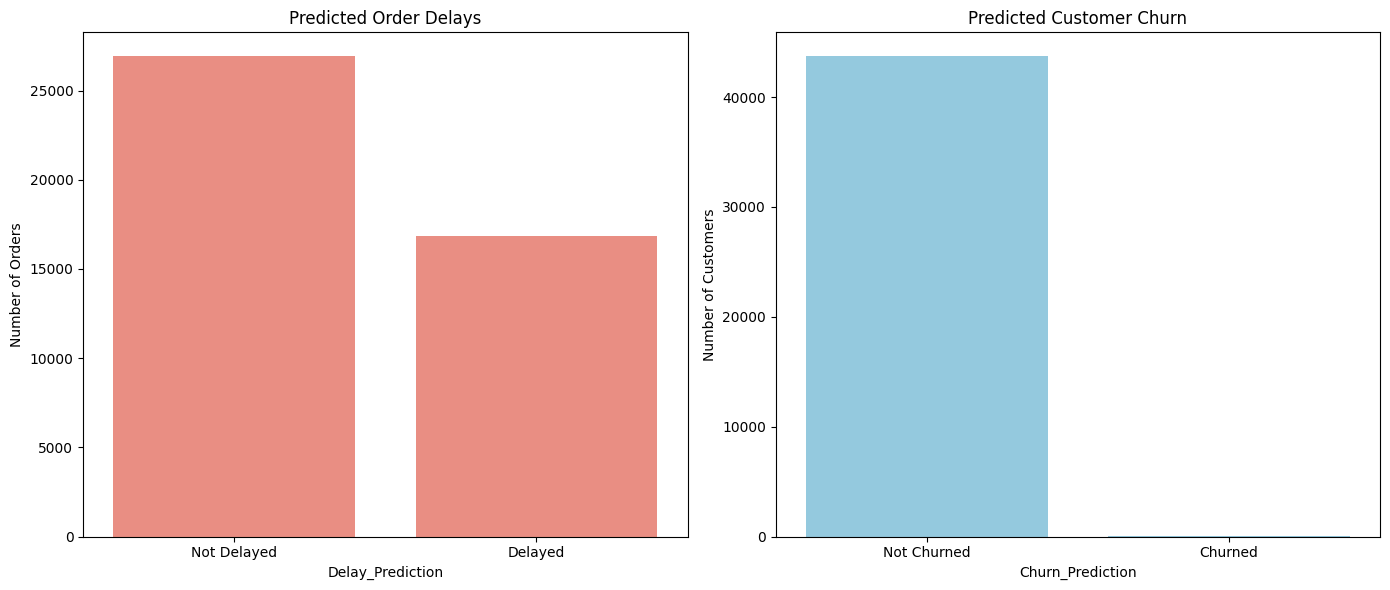

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare counts ---
delay_counts = new_data['Delay_Prediction'].value_counts().sort_index()
churn_counts = new_data['Churn_Prediction'].value_counts().sort_index()

# --- Plot side by side ---
plt.figure(figsize=(14, 6))

# Delay Prediction
plt.subplot(1, 2, 1)
sns.barplot(x=delay_counts.index, y=delay_counts.values, color="salmon")
plt.xticks([0,1], ['Not Delayed', 'Delayed'])
plt.ylabel("Number of Orders")
plt.title("Predicted Order Delays")

# Churn Prediction
plt.subplot(1, 2, 2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, color="skyblue")
plt.xticks([0,1], ['Not Churned', 'Churned'])
plt.ylabel("Number of Customers")
plt.title("Predicted Customer Churn")

plt.tight_layout()
plt.show()


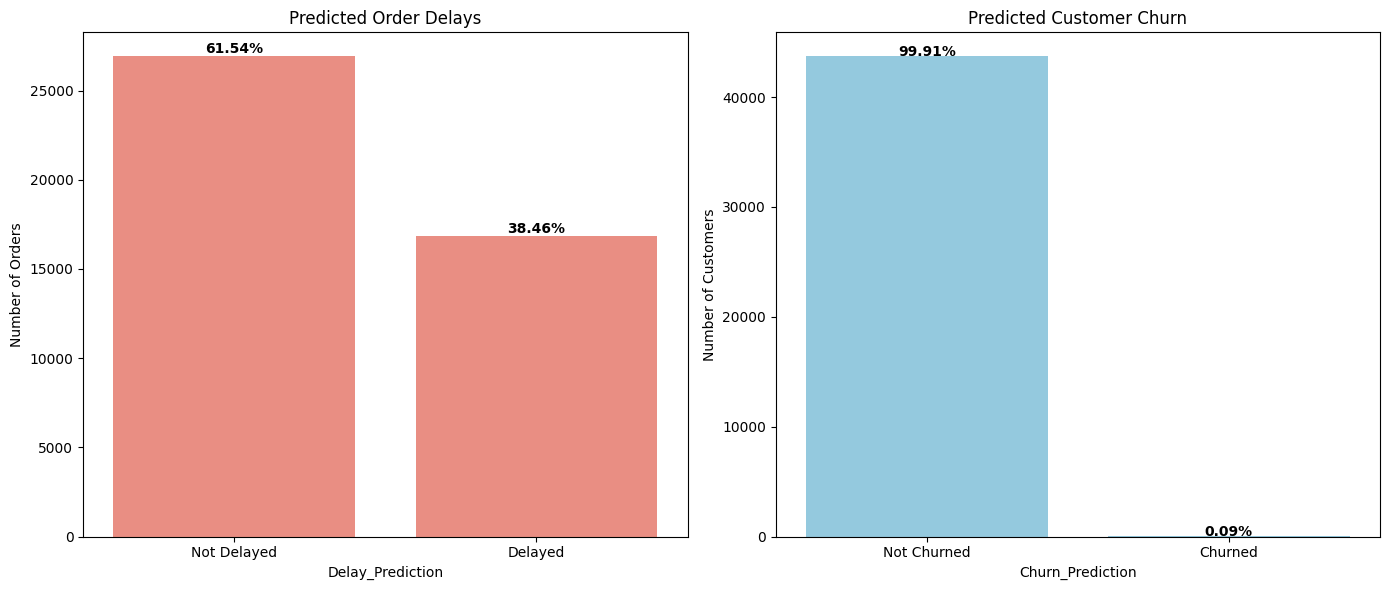

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare counts ---
delay_counts = new_data['Delay_Prediction'].value_counts().sort_index()
churn_counts = new_data['Churn_Prediction'].value_counts().sort_index()

# --- Plot side by side ---
plt.figure(figsize=(14, 6))

# Delay Prediction
plt.subplot(1, 2, 1)
sns.barplot(x=delay_counts.index, y=delay_counts.values, color="salmon")
plt.xticks([0,1], ['Not Delayed', 'Delayed'])
plt.ylabel("Number of Orders")
plt.title("Predicted Order Delays")
# Add percentages
for i, count in enumerate(delay_counts.values):
    plt.text(i, count + 200, f"{count/len(new_data)*100:.2f}%", ha='center', fontweight='bold')

# Churn Prediction
plt.subplot(1, 2, 2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, color="skyblue")
plt.xticks([0,1], ['Not Churned', 'Churned'])
plt.ylabel("Number of Customers")
plt.title("Predicted Customer Churn")
# Add percentages
for i, count in enumerate(churn_counts.values):
    plt.text(i, count + 50, f"{count/len(new_data)*100:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


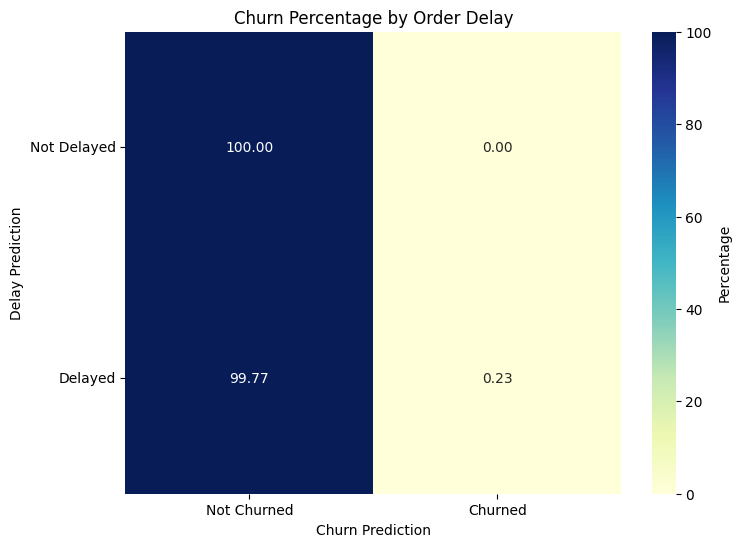

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cross-tabulation ---
delay_churn_ct = pd.crosstab(new_data['Delay_Prediction'], new_data['Churn_Prediction'], normalize='index') * 100

# --- Plot ---
plt.figure(figsize=(8,6))
sns.heatmap(delay_churn_ct, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.xticks([0.5,1.5], ['Not Churned', 'Churned'], rotation=0)
plt.yticks([0.5,1.5], ['Not Delayed', 'Delayed'], rotation=0)
plt.xlabel("Churn Prediction")
plt.ylabel("Delay Prediction")
plt.title("Churn Percentage by Order Delay")
plt.show()


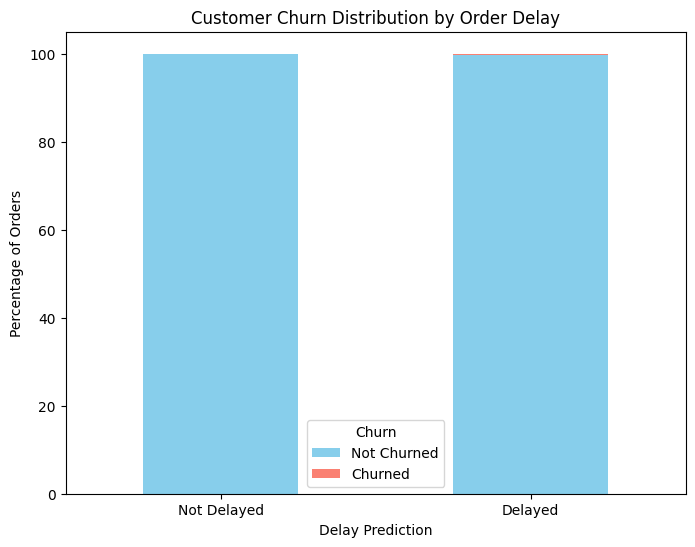

In [9]:
# --- Prepare data ---
stacked_data = new_data.groupby('Delay_Prediction')['Churn_Prediction'].value_counts(normalize=True).unstack().fillna(0) * 100
stacked_data.rename(columns={0:'Not Churned', 1:'Churned'}, inplace=True)

# --- Plot ---
stacked_data.plot(kind='bar', stacked=True, figsize=(8,6), color=['skyblue', 'salmon'])
plt.ylabel("Percentage of Orders")
plt.xlabel("Delay Prediction")
plt.title("Customer Churn Distribution by Order Delay")
plt.legend(title="Churn")
plt.xticks(ticks=[0,1], labels=['Not Delayed', 'Delayed'], rotation=0)
plt.show()


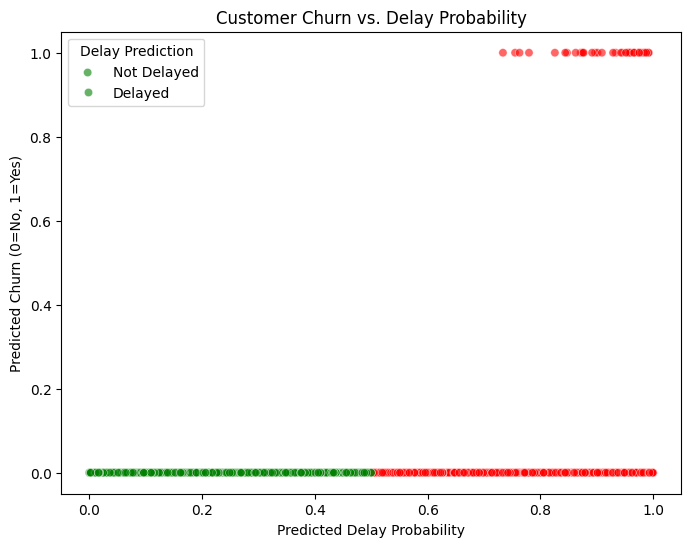

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=new_data['Delay_Probability'],
    y=new_data['Churn_Prediction'],  # or 'Churn_Probability' if you have it
    hue=new_data['Delay_Prediction'], # color by actual predicted delay
    palette=['green','red'],
    alpha=0.6
)
plt.xlabel("Predicted Delay Probability")
plt.ylabel("Predicted Churn (0=No, 1=Yes)")
plt.title("Customer Churn vs. Delay Probability")
plt.legend(title="Delay Prediction", labels=['Not Delayed','Delayed'])
plt.show()


In [11]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


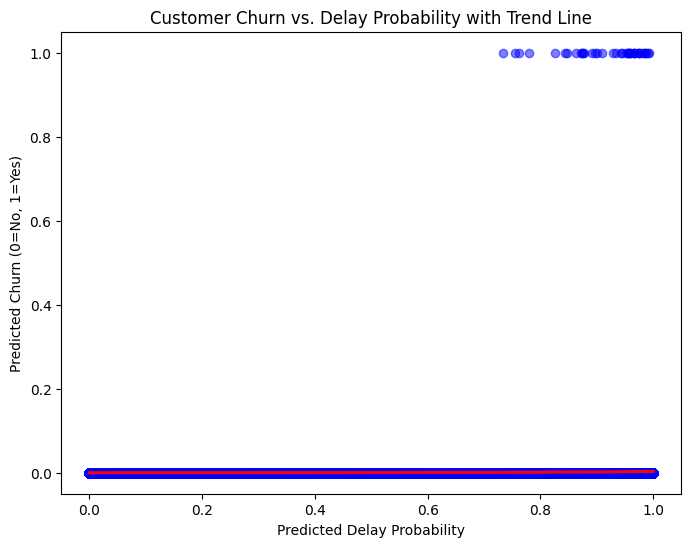

In [12]:
plt.figure(figsize=(8,6))
sns.regplot(
    x=new_data['Delay_Probability'],
    y=new_data['Churn_Prediction'],
    logistic=True,  # logistic regression since churn is binary
    scatter_kws={'alpha':0.5, 'color':'blue'},
    line_kws={'color':'red'}
)
plt.xlabel("Predicted Delay Probability")
plt.ylabel("Predicted Churn (0=No, 1=Yes)")
plt.title("Customer Churn vs. Delay Probability with Trend Line")
plt.show()


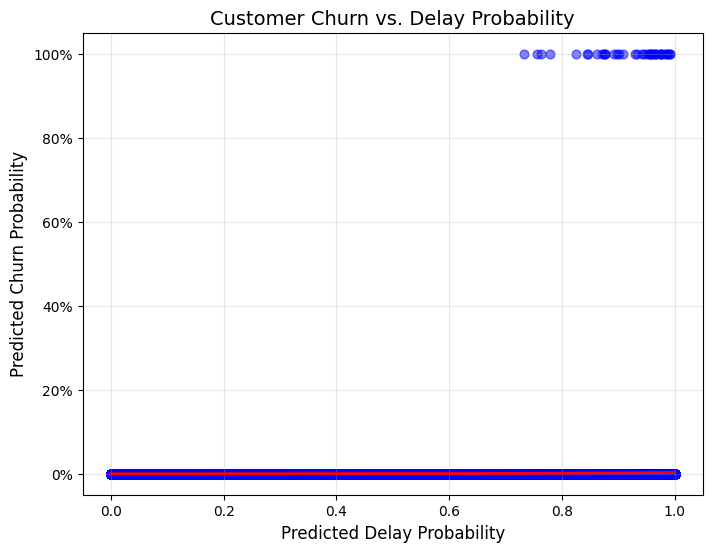

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

plt.figure(figsize=(8,6))
sns.regplot(
    x=new_data['Delay_Probability'],
    y=new_data['Churn_Prediction'],
    logistic=True,
    scatter_kws={'alpha':0.5, 'color':'blue', 's':40},
    line_kws={'color':'red', 'lw':2}
)

plt.xlabel("Predicted Delay Probability", fontsize=12)
plt.ylabel("Predicted Churn Probability", fontsize=12)
plt.title("Customer Churn vs. Delay Probability", fontsize=14)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.grid(alpha=0.3)
plt.show()


In [14]:
# 📌 Notebook 4: Fast Inference-Only Version

import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# --- 1️⃣ Load Models & Data ---
delay_model = joblib.load("../models/delay_prediction_xgb.pkl")
churn_pipeline = joblib.load("../models/final_churn_pipeline.pkl")
data_path = "../data/cleaned_amazon_delivery.csv"
new_data = pd.read_csv(data_path)
print("✅ Data and models loaded. Total rows:", len(new_data))

# --- 2️⃣ Feature Engineering ---
new_data['Order_Hour'] = pd.to_datetime(new_data['Order_Time'], format='%H:%M:%S', errors='coerce').dt.hour
new_data['Order_DayOfWeek'] = pd.to_datetime(new_data['Order_Date'], format='%Y-%m-%d', errors='coerce').dt.dayofweek
new_data['Order_Month'] = pd.to_datetime(new_data['Order_Date'], format='%Y-%m-%d', errors='coerce').dt.month
new_data['Distance_km'] = np.sqrt(
    (new_data['Store_Latitude'] - new_data['Drop_Latitude'])**2 +
    (new_data['Store_Longitude'] - new_data['Drop_Longitude'])**2
)

# --- 3️⃣ Encode Categorical Features ---
categorical_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for col in categorical_cols:
    if col in new_data.columns:
        new_data[col] = new_data[col].fillna("Unknown").astype(str)
        le = LabelEncoder()
        new_data[col] = le.fit_transform(new_data[col]).astype(int)

# --- 4️⃣ Predict Delivery Delay ---
delay_features = [
    'Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle',
    'Area', 'Category', 'Order_Hour', 'Order_DayOfWeek',
    'Order_Month', 'Distance_km'
]
X_delay = new_data[delay_features].fillna(0).copy()
new_data['Delay_Prediction'] = delay_model.predict(X_delay)
new_data['Delay_Probability'] = delay_model.predict_proba(X_delay)[:,1]
new_data['Is_Delayed'] = new_data['Delay_Prediction']

# --- 5️⃣ Predict Customer Churn ---
X_churn = new_data.drop(columns=['Churned'], errors='ignore')
new_data['Churn_Prediction'] = churn_pipeline.predict(X_churn)

# --- 6️⃣ Summary Report ---
print("Total Orders:", len(new_data))
print(f"Predicted Delayed Orders: {new_data['Delay_Prediction'].mean()*100:.2f}%")
print(f"Predicted Churned Customers: {new_data['Churn_Prediction'].mean()*100:.2f}%")
print("\nSample Predictions:")
print(new_data[['Order_ID','Delay_Prediction','Delay_Probability','Churn_Prediction']].head())

# --- 7️⃣ Save Final Predictions ---
output_path = "../data/final_predictions.csv"
new_data.to_csv(output_path, index=False)
print("✅ Predictions complete! File saved to:", output_path)


✅ Data and models loaded. Total rows: 43739
Total Orders: 43739
Predicted Delayed Orders: 38.46%
Predicted Churned Customers: 0.09%

Sample Predictions:
        Order_ID  Delay_Prediction  Delay_Probability  Churn_Prediction
0  ialx566343618                 0           0.002577                 0
1  akqg208421122                 1           0.998834                 0
2  njpu434582536                 0           0.119285                 0
3  rjto796129700                 0           0.052083                 0
4  zguw716275638                 1           0.992815                 0
✅ Predictions complete! File saved to: ../data/final_predictions.csv


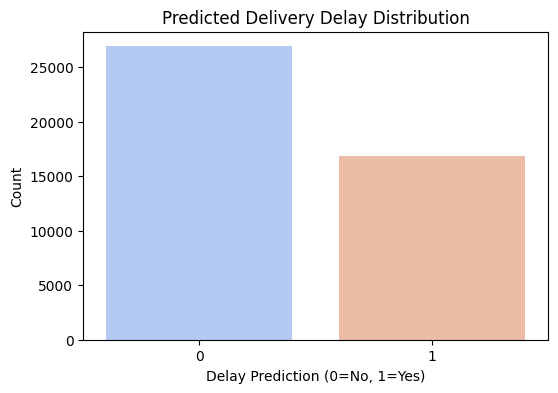

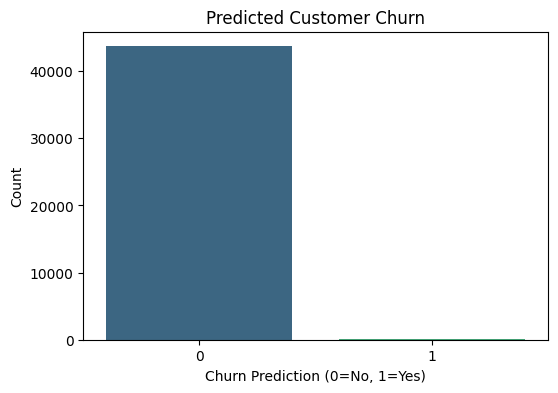

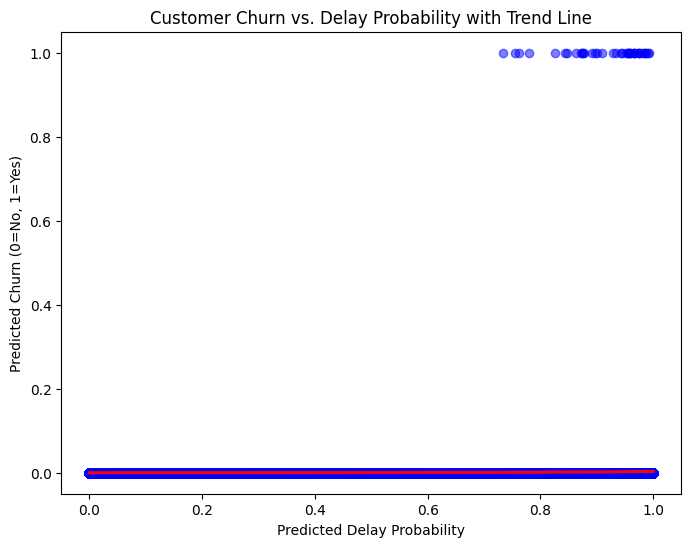

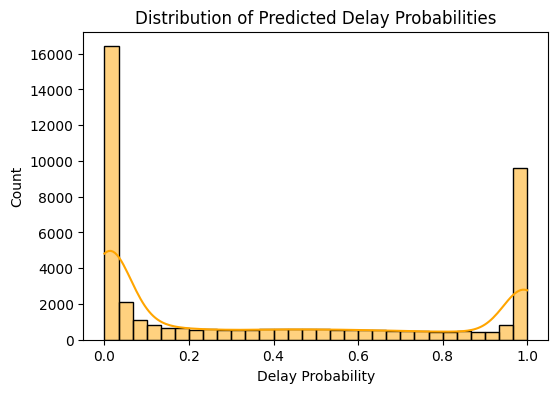

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Delay Prediction Distribution ---
plt.figure(figsize=(6,4))
delay_counts = new_data['Delay_Prediction'].value_counts()
sns.barplot(x=delay_counts.index, y=delay_counts.values, palette="coolwarm")
plt.xlabel("Delay Prediction (0=No, 1=Yes)")
plt.ylabel("Count")
plt.title("Predicted Delivery Delay Distribution")
plt.show()

# --- 2️⃣ Churn Prediction Distribution ---
plt.figure(figsize=(6,4))
churn_counts = new_data['Churn_Prediction'].value_counts()
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.xlabel("Churn Prediction (0=No, 1=Yes)")
plt.ylabel("Count")
plt.title("Predicted Customer Churn")
plt.show()

# --- 3️⃣ Delay Probability vs Churn Scatter with Logistic Trend ---
plt.figure(figsize=(8,6))
sns.regplot(
    x=new_data['Delay_Probability'],
    y=new_data['Churn_Prediction'],
    logistic=True,  # binary outcome
    scatter_kws={'alpha':0.5, 'color':'blue'},
    line_kws={'color':'red'}
)
plt.xlabel("Predicted Delay Probability")
plt.ylabel("Predicted Churn (0=No, 1=Yes)")
plt.title("Customer Churn vs. Delay Probability with Trend Line")
plt.show()

# --- 4️⃣ Histogram of Delay Probabilities ---
plt.figure(figsize=(6,4))
sns.histplot(new_data['Delay_Probability'], bins=30, kde=True, color='orange')
plt.xlabel("Delay Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Delay Probabilities")
plt.show()


✅ Data and models loaded. Total rows: 43739
✅ Predictions complete! File saved to: ../data/final_predictions.csv

📊 Summary Report
Total Orders Processed: 43739
Predicted Delayed Orders: 38.46%
Predicted Churned Customers: 0.09%

🔍 Sample Predictions:


,Order_ID,Delay_Prediction,Delay_Probability,Churn_Prediction
0,ialx566343618,0,0.002577,0
1,akqg208421122,1,0.998834,0
2,njpu434582536,0,0.119285,0
3,rjto796129700,0,0.052083,0
4,zguw716275638,1,0.992815,0


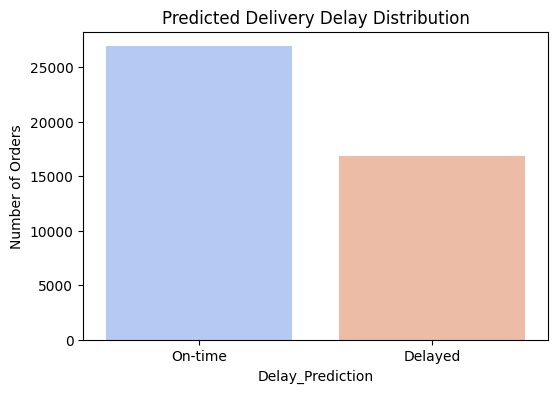

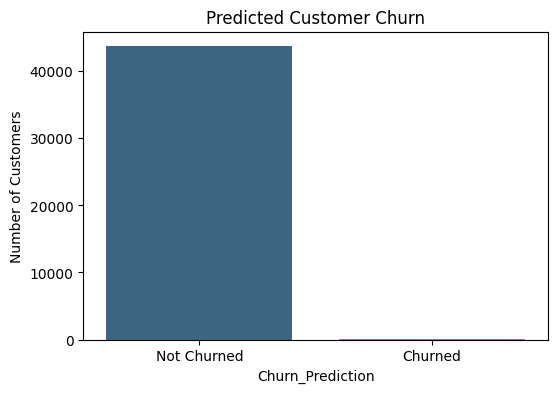

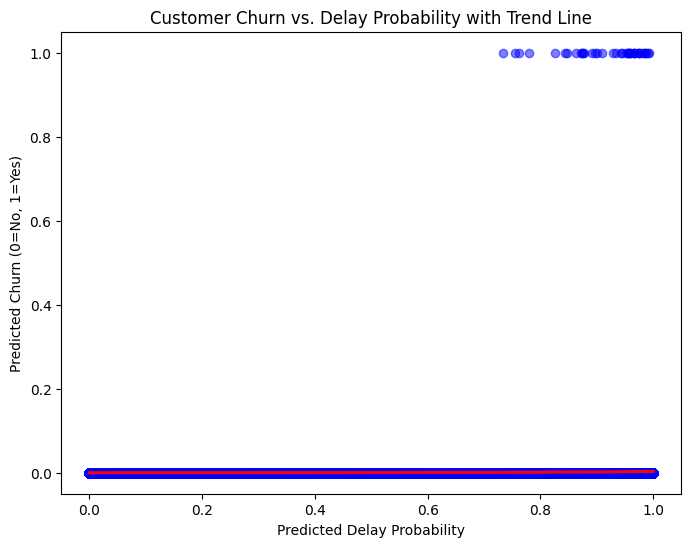


Top 10 Orders Most Likely to be Delayed:


,Order_ID,Delay_Probability,Delay_Prediction,Agent_Age,Vehicle,Area
31423,tigq486348614,0.999990,1,38,2,0
7309,nrid516202395,0.999990,1,38,3,0
38760,xfcl665383824,0.999990,1,35,2,0
5522,feth036591020,0.999990,1,37,1,0
10774,dpkk289652203,0.999986,1,38,1,0
16480,nebp089023584,0.999986,1,35,2,0
28416,htkn000218947,0.999986,1,37,1,2
31912,ohzu044354016,0.999986,1,39,1,0
32010,ojts074588733,0.999985,1,36,3,0
30636,ogbq166319058,0.999984,1,35,3,0



Top 10 Customers Most Likely to Churn:


,Order_ID,Churn_Prediction,Is_Delayed,Delay_Probability,Agent_Age,Area
20410,cmwm601994587,1,1,0.901352,15,0
15307,jbvk101196693,1,1,0.955183,15,0
2779,oilg311747812,1,1,0.959579,15,0
11610,dlmc121704817,1,1,0.985697,15,0
2286,xige084493792,1,1,0.755175,15,3
15826,iext295340417,1,1,0.897044,15,3
10687,wxzn327559387,1,1,0.779787,15,3
21446,jthh363774386,1,1,0.965913,15,0
5659,pjec796867569,1,1,0.955903,15,0
15458,fgzz513029577,1,1,0.945185,15,0


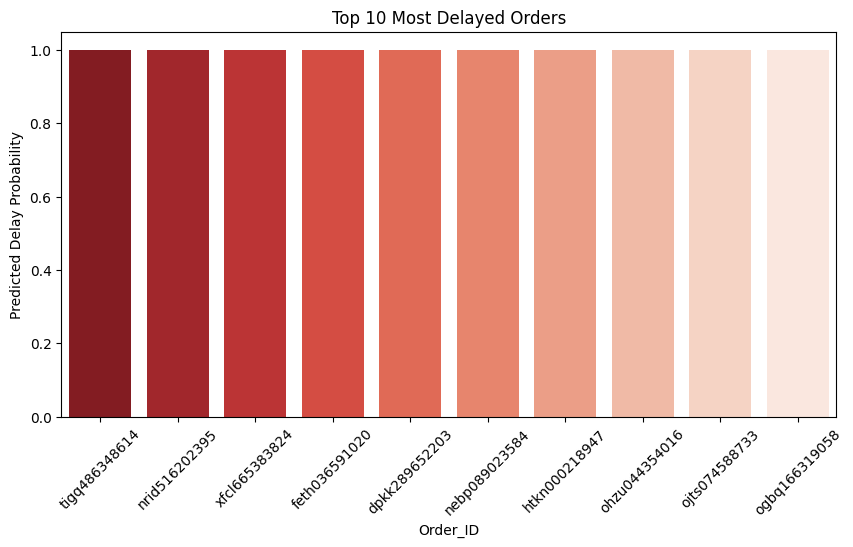

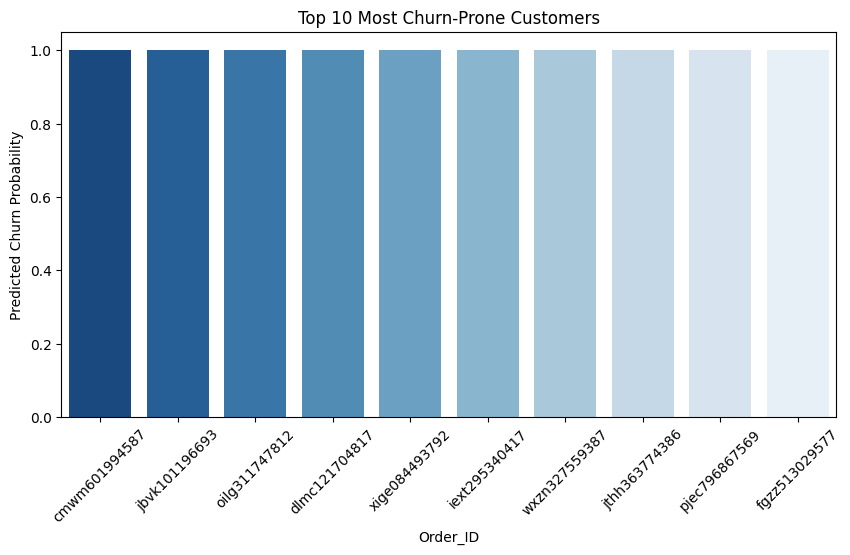

In [16]:
# ===============================
# 📌 Notebook 4: Inference & Integration (Complete Version)
# ===============================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ===============================
# 1. Load trained models
# ===============================
delay_model = joblib.load("../models/delay_prediction_xgb.pkl")
churn_pipeline = joblib.load("../models/final_churn_pipeline.pkl")

# ===============================
# 2. Load cleaned dataset
# ===============================
data_path = "../data/cleaned_amazon_delivery.csv"
new_data = pd.read_csv(data_path)
print(f"✅ Data and models loaded. Total rows: {new_data.shape[0]}")

# ===============================
# 3. Feature Engineering
# ===============================
new_data['Order_Hour'] = pd.to_datetime(new_data['Order_Time'], errors='coerce').dt.hour
new_data['Order_DayOfWeek'] = pd.to_datetime(new_data['Order_Date'], errors='coerce').dt.dayofweek
new_data['Order_Month'] = pd.to_datetime(new_data['Order_Date'], errors='coerce').dt.month

new_data['Distance_km'] = np.sqrt(
    (new_data['Store_Latitude'] - new_data['Drop_Latitude'])**2 +
    (new_data['Store_Longitude'] - new_data['Drop_Longitude'])**2
)

# ===============================
# 4. Encode categorical columns
# ===============================
categorical_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for col in categorical_cols:
    if col in new_data.columns:
        new_data[col] = new_data[col].fillna("Unknown").astype(str)
        le = LabelEncoder()
        new_data[col] = le.fit_transform(new_data[col]).astype(int)

# ===============================
# 5. Predict Delay
# ===============================
delay_features = [
    'Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle',
    'Area', 'Category', 'Order_Hour', 'Order_DayOfWeek',
    'Order_Month', 'Distance_km'
]

X_delay = new_data[delay_features].fillna(0).copy()
new_data['Delay_Prediction'] = delay_model.predict(X_delay)
new_data['Delay_Probability'] = delay_model.predict_proba(X_delay)[:, 1]

# Needed for churn pipeline
new_data['Is_Delayed'] = new_data['Delay_Prediction']

# ===============================
# 6. Predict Churn
# ===============================
X_churn = new_data.drop(columns=['Churned'], errors='ignore')
new_data['Churn_Prediction'] = churn_pipeline.predict(X_churn)

# ===============================
# 7. Save Results
# ===============================
output_path = "../data/final_predictions.csv"
new_data.to_csv(output_path, index=False)
print("✅ Predictions complete! File saved to:", output_path)

# ===============================
# 8. Summary Report
# ===============================
total_orders = len(new_data)
delayed_pct = new_data['Delay_Prediction'].mean() * 100
churn_pct = new_data['Churn_Prediction'].mean() * 100

print("\n📊 Summary Report")
print("Total Orders Processed:", total_orders)
print(f"Predicted Delayed Orders: {delayed_pct:.2f}%")
print(f"Predicted Churned Customers: {churn_pct:.2f}%")

print("\n🔍 Sample Predictions:")
display(new_data[['Order_ID', 'Delay_Prediction', 'Delay_Probability', 'Churn_Prediction']].head())

# ===============================
# 9. Visualizations
# ===============================

# Delay distribution
plt.figure(figsize=(6,4))
delay_counts = new_data['Delay_Prediction'].value_counts()
sns.barplot(x=delay_counts.index, y=delay_counts.values, palette="coolwarm")
plt.xticks([0,1], ['On-time', 'Delayed'])
plt.ylabel("Number of Orders")
plt.title("Predicted Delivery Delay Distribution")
plt.show()

# Churn distribution
plt.figure(figsize=(6,4))
churn_counts = new_data['Churn_Prediction'].value_counts()
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.xticks([0,1], ['Not Churned', 'Churned'])
plt.ylabel("Number of Customers")
plt.title("Predicted Customer Churn")
plt.show()

# Delay Probability vs Churn
plt.figure(figsize=(8,6))
sns.regplot(
    x=new_data['Delay_Probability'],
    y=new_data['Churn_Prediction'],
    logistic=True,
    scatter_kws={'alpha':0.5, 'color':'blue'},
    line_kws={'color':'red'}
)
plt.xlabel("Predicted Delay Probability")
plt.ylabel("Predicted Churn (0=No, 1=Yes)")
plt.title("Customer Churn vs. Delay Probability with Trend Line")
plt.show()

# ===============================
# 10. Top Risk Orders & Churn Customers
# ===============================

# Top 10 orders most likely to be delayed
top_delayed_orders = new_data.sort_values(by='Delay_Probability', ascending=False).head(10)
print("\nTop 10 Orders Most Likely to be Delayed:")
display(top_delayed_orders[['Order_ID', 'Delay_Probability', 'Delay_Prediction', 'Agent_Age', 'Vehicle', 'Area']])

# Top 10 customers most likely to churn
top_churn_customers = new_data.sort_values(by='Churn_Prediction', ascending=False).head(10)
print("\nTop 10 Customers Most Likely to Churn:")
display(top_churn_customers[['Order_ID', 'Churn_Prediction', 'Is_Delayed', 'Delay_Probability', 'Agent_Age', 'Area']])

# Visualization: Top delayed orders
plt.figure(figsize=(10,5))
sns.barplot(
    x='Order_ID', 
    y='Delay_Probability', 
    data=top_delayed_orders, 
    palette='Reds_r'
)
plt.xticks(rotation=45)
plt.ylabel("Predicted Delay Probability")
plt.title("Top 10 Most Delayed Orders")
plt.show()

# Visualization: Top churn customers
plt.figure(figsize=(10,5))
sns.barplot(
    x='Order_ID', 
    y='Churn_Prediction', 
    data=top_churn_customers, 
    palette='Blues_r'
)
plt.xticks(rotation=45)
plt.ylabel("Predicted Churn Probability")
plt.title("Top 10 Most Churn-Prone Customers")
plt.show()
